## Notebooks to check

https://www.kaggle.com/foolofatook/starter-eda-cassava-leaf-disease

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam 
from sklearn.utils import shuffle
from tqdm import tqdm
from PIL import Image

In [2]:
!ls

CassavaLeafDiseaseClassification.ipynb	 dataset
cassava_model				 myCustomGenerator.py
cassava_mode_ya_nne.data-00000-of-00002  one_hot_encoded.csv
cassava_mode_ya_nne.data-00001-of-00002  prediction.ipynb
cassava_mode_ya_nne.index		 prediction.py
cassava_mode_ya_pili			 __pycache__
cassava_mode_ya_tatu			 training.py
checkpoint


In [3]:
train = pd.read_csv('dataset/train.csv')
train['label'] = train['label'].astype('str')
train.sample(5)

,image_id,label
13448,3404585769.jpg,3
1648,1288328953.jpg,3
8358,2484471054.jpg,3
19033,551875095.jpg,3
14966,3687904505.jpg,2


In [4]:
train.shape

(21397, 2)

In [5]:
names_of_disease = pd.read_json('dataset/label_num_to_disease_map.json', typ='series')
names_of_disease

0         Cassava Bacterial Blight (CBB)
1    Cassava Brown Streak Disease (CBSD)
2             Cassava Green Mottle (CGM)
3           Cassava Mosaic Disease (CMD)
4                                Healthy
dtype: object

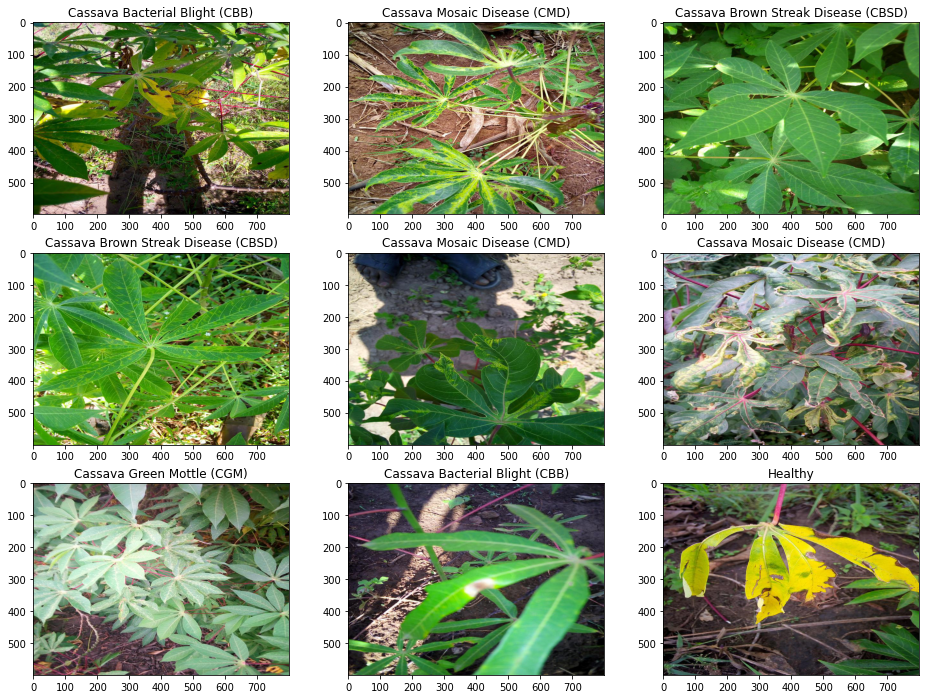

In [6]:
plt.figure(figsize=(16, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    image = Image.open('dataset/train_images/' + train.iloc[i]['image_id'])
    array = np.array(image)
    plt.imshow(array)
    label=train.iloc[i]['label']
    plt.title(f'{names_of_disease[int(label)]}')
plt.show()

In [7]:
one_coded_dataset = pd.get_dummies(train,columns=['label'])
one_coded_dataset.to_csv('one_hot_encoded.csv')
one_coded_dataset.head()

,image_id,label_0,label_1,label_2,label_3,label_4
0,1000015157.jpg,1,0,0,0,0
1,1000201771.jpg,0,0,0,1,0
2,100042118.jpg,0,1,0,0,0
3,1000723321.jpg,0,1,0,0,0
4,1000812911.jpg,0,0,0,1,0


In [8]:
sizes = []
for i in range(1, len(train), 250):
    image = Image.open('dataset/train_images/' + train.iloc[i]['image_id'])
    array = np.array(image)
    sizes.append(array.shape)
print('Picture size', set(sizes))

Picture size {(600, 800, 3)}


In [9]:
img_width, img_height = 224, 224

In [10]:
datagen = ImageDataGenerator(validation_split=0.2,
                             rotation_range = 40,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             vertical_flip=True,
                             horizontal_flip=True)

train_datagen_flow = datagen.flow_from_dataframe(
    dataframe=train,
    directory='dataset/train_images',
    x_col='image_id',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=64,
    subset='training',
    seed=12345)


valid_datagen_flow = datagen.flow_from_dataframe(
    dataframe=train,
    directory='dataset/train_images',
    x_col='image_id',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=64,
    class_mode = 'categorical',
    subset='validation',
    seed=12345)

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [11]:
current_balance = train['label'].value_counts(normalize=True)
current_balance

3    0.614946
4    0.120437
2    0.111511
1    0.102304
0    0.050802
Name: label, dtype: float64

In [12]:
class_weight = {0: (1 - current_balance[0]) / (1 - current_balance.min()),
                1: (1 - current_balance[1]) / (1 - current_balance.min()),
                2: (1 - current_balance[2]) / (1 - current_balance.min()),
                3: (1 - current_balance[3]) / (1 - current_balance.min()),
                4: (1 - current_balance[4]) / (1 - current_balance.min())}

class_weight

{0: 0.4056622353520434,
 1: 0.9266371245691778,
 2: 0.9360413589364845,
 3: 0.9457410142786805,
 4: 1.0}

In [13]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu', input_shape=(224,224,3)))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.25))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=3))
#model.add(GlobalMaxPool2D())
model.add(Dropout(0.5))
    
model.add(Flatten())
model.add(Dense(512, activation='relu'))  # Fully connected layer
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(60, activation="relu"))  # Fully connected layer
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5, activation="softmax"))  # Classification layer or output layer

opt = tf.keras.optimizers.Adam(lr = 0.001)

model.compile(optimizer= opt, loss= 'categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 64)      4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 220, 220, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 216, 216, 64)      102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 108, 108, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 108, 108, 64)      256       
_________________________________________________________________
dropout (Dropout)            (None, 108, 108, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 104, 104, 128)     2

In [14]:
early_stop = EarlyStopping(monitor = "val_loss",
                                min_delta=0.001,
                                patience=3,
                                verbose=1,
                                mode="min",
                                #baseline=None,
                                restore_best_weights=False)

reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                factor=0.1,
                                patience=3,
                                verbose=1,
                                mode="min",
                                min_delta=0.0001)

optimizer = Adam(lr=0.001)

model.compile(loss="categorical_crossentropy", 
              optimizer=optimizer, 
              metrics=["accuracy"])

In [ ]:
history = model.fit(train_datagen_flow,
                    validation_data=valid_datagen_flow, 
                    epochs=50,
                    callbacks=[early_stop, reduce_lr], 
                    #use_multiprocessing=True,
                    shuffle=True,
                    verbose=2)

Epoch 1/50


In [ ]:
#loading the images

train_image = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img('cassava-leaf-disease-classification/train_images/'+train['image_id'][i], 
                         color_mode = 'rgb',target_size=None, interpolation ='nearest')
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

 12%|█▏        | 2628/21397 [00:31<04:39, 67.05it/s]

In [17]:
#loading the images

train_image = []
for i in tqdm(range(1)):
    img = image.load_img('dataset/train_images/'+train['image_id'][i], 
                         color_mode = 'rgb',target_size=None, interpolation ='nearest')
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 1/1 [00:00<00:00, 57.88it/s]


In [19]:
X.shape

(1, 600, 800, 3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
X_test.shape

In [ ]:
y_test.shape